# Spatial Statistics and Machine Learning -  Case Study: The Reprise of the Far Right
## Investigating Spatial Heterogeneity in Far-Right Voting Behaviour in the 2025 German Federal Elections

### Authors:
- Marion Späth		2772981
- Katia Tseliou		2500434
- Morgan Arima		9374752
- Joris Burger		0859427


### Research Questions: 
1. What factors influenced far-right voting behavior for the AfD in the 2025 German general elections?
2. To what extent does the explanatory power of different factors vary across space?

# PART 3:

This code was used for to estimate the Random Forest and the Spatial Random Forest.

**Random Forest General Steps**

1) Preprocess Data

2) Non-Spatial Random Forest

3) Spatially-Aware random Forest

   - Incorporate Spatial Lag Features

4)  Use Moran’s I on the residuals  to determine spatial patterns

**1. Preprocess Data**
 - Identify numeric and categorical variables.
   

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
df_full= gpd.read_file('sample_data/df_full_v2.gpkg')



print(df_full.columns)
df=gpd.read_file("sample_data/variables_scaled.gpkg")
# List of missing columns
missing_columns = ['target_id', 'WKR_NR', 'LAND_NR', 'WKR_NAME', 'LAND_NAME']

# Adding the missing columns from the old dataset to the new dataset
df[missing_columns] = df_full[missing_columns]

# Now, df contains the missing columns from df_full
print(df.columns)  # Check the result

# Look at dataset columns and types
print(df.info())
print(df.columns)
# check the head
# print(df.head())

# Determine which columns are numeric
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()


Index(['target_id', 'WKR_NR', 'WKR_NAME', 'LAND_NR', 'LAND_NAME',
       'Gebietsname', 'Gruppenname', 'Prozent', 'VorpProzent', 'east',
       'percentAfD25', 'percentAfD21', 'prop_foreigners_mean', 'avg_age_mean',
       'prop_houseowners_mean', 'avg_rent_SQM_mean', 'avg_livingspace_mean',
       'population_count_sum', 'below18_sum', 'a18-29_sum', 'a30-49_sum',
       'a50-64_sum', 'above64_sum', 'proportion_agriculture_interpolated',
       'disposable_income_interpolated',
       'proportion_residential_transport_interpolated',
       'unemployment_rate_interpolated', 'crime_count_per100.000_interpolated',
       'area_sqm', 'population_density_km2', 'prop_18-29', 'prop_above64',
       'attack', 'distance_terror', 'geometry'],
      dtype='object')
Index(['east', 'percentAfD21', 'prop_foreigners_mean', 'avg_age_mean',
       'avg_rent_SQM_mean', 'avg_livingspace_mean', 'population_count_sum',
       'proportion_agriculture_interpolated', 'disposable_income_interpolated',
       '

**2. Train Non Spatial Random Forest model**

- Examine geometries and units of geography
- Train/test split: Initially split the data randomly.
- Fit a standard Random Forest model on the training data.
- Calcualte R2 and MAE on tesst set
- Calculate Feature Importance to identify global predictors of AfD support.

In [4]:
# Cluster based splitting. Splitting based upon the already existing regions (constituencies) is the most logical approach here
import geopandas as gpd

# continue process with df_full renamed as df
df = df_full.copy()

# check the first rows and columns
print(df.head())
print(df.columns)

# Check if the geometry is right.
print(df.geom_type.value_counts())
print(df.crs)  # Check the coordinate reference system


   target_id  WKR_NR                           WKR_NAME LAND_NR  \
0          0       1              Flensburg – Schleswig      01   
1          1       2  Nordfriesland – Dithmarschen Nord      01   
2          2       3       Steinburg – Dithmarschen Süd      01   
3          3       4              Rendsburg-Eckernförde      01   
4          4       5                               Kiel      01   

            LAND_NAME                        Gebietsname Gruppenname  \
0  Schleswig-Holstein              Flensburg – Schleswig         AfD   
1  Schleswig-Holstein  Nordfriesland – Dithmarschen Nord         AfD   
2  Schleswig-Holstein       Steinburg – Dithmarschen Süd         AfD   
3  Schleswig-Holstein              Rendsburg-Eckernförde         AfD   
4  Schleswig-Holstein                               Kiel         AfD   

     Prozent VorpProzent  east  ...  \
0  15,256022    5,775787     0  ...   
1  16,065402    6,103576     0  ...   
2  20,360017    8,365838     0  ...   
3  16,02

In [5]:
# Check for the unique states
print(df["LAND_NAME"].unique())

# Count the number of constituencies per state
print(df["LAND_NAME"].value_counts())


['Schleswig-Holstein' 'Mecklenburg-Vorpommern' 'Hamburg' 'Niedersachsen'
 'Bremen' 'Brandenburg' 'Sachsen-Anhalt' 'Berlin' 'Nordrhein-Westfalen'
 'Sachsen' 'Hessen' 'Thüringen' 'Rheinland-Pfalz' 'Bayern'
 'Baden-Württemberg' 'Saarland']
LAND_NAME
Nordrhein-Westfalen       64
Bayern                    47
Baden-Württemberg         38
Niedersachsen             30
Hessen                    22
Sachsen                   16
Rheinland-Pfalz           15
Berlin                    12
Schleswig-Holstein        11
Brandenburg               10
Thüringen                  8
Sachsen-Anhalt             8
Mecklenburg-Vorpommern     6
Hamburg                    6
Saarland                   4
Bremen                     2
Name: count, dtype: int64


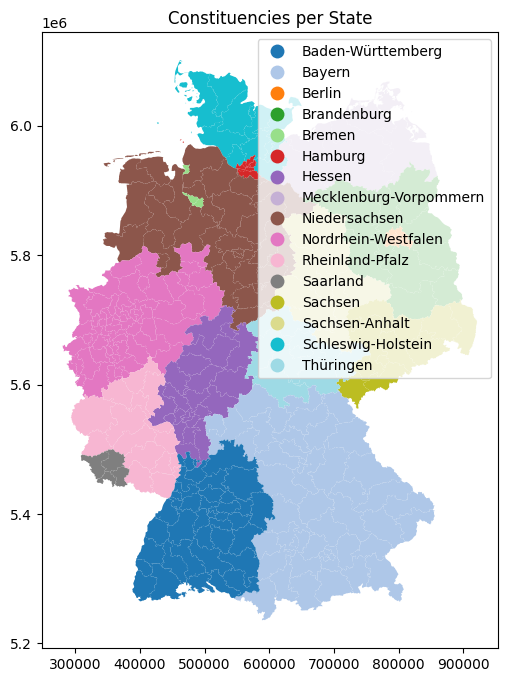

In [6]:
import matplotlib.pyplot as plt

# Make a plot of  constituencies, colored per state
fig, ax = plt.subplots(figsize=(10, 8))
df.plot(column="LAND_NAME", cmap="tab20", legend=True, ax=ax)
plt.title("Constituencies per State")
plt.show()


Make a random selection of the constituencies by state for the train set. you can rerun these many times and get different constituencies.

In [7]:
import numpy as np
import pandas as pd

# Set a random seed for consistency across runs
random_seed = 42
np.random.seed(random_seed)

# Number of constituencies to select for the test set (20% of 299)
test_size = 60 # 20% of 299 constituencies

# Randomly select constituencies for the test set
constituencies_test = np.random.choice(df.index, size=test_size, replace=False)

# Create the train and test sets
df_test = df.loc[constituencies_test]
df_train = df.drop(constituencies_test)
# Create the train and test sets
df_test = df.loc[constituencies_test]
df_train = df.drop(constituencies_test)

# Check the distribution
print(f"Train set: {len(df_train)} constituencies")
print(f"Test set: {len(df_test)} constituencies")

# Optional: print first few rows to confirm
print("\nFirst few rows of the test set:")
print(df_test.head())

Train set: 239 constituencies
Test set: 60 constituencies

First few rows of the test set:
     target_id  WKR_NR                            WKR_NAME LAND_NR  \
281        281     282                  Lörrach – Müllheim      08   
265        265     266                        Neckar-Zaber      08   
164        164     165                       Vogtlandkreis      14   
9            9      10  Herzogtum Lauenburg – Stormarn-Süd      01   
77          77      78          Berlin-Steglitz-Zehlendorf      11   

              LAND_NAME                         Gebietsname Gruppenname  \
281   Baden-Württemberg                  Lörrach – Müllheim         AfD   
265   Baden-Württemberg                        Neckar-Zaber         AfD   
164             Sachsen                       Vogtlandkreis         AfD   
9    Schleswig-Holstein  Herzogtum Lauenburg – Stormarn-Süd         AfD   
77               Berlin          Berlin-Steglitz-Zehlendorf         AfD   

       Prozent VorpProzent  east  ...

<ipython-input-8-60077a4b3af5>:4: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
<ipython-input-8-60077a4b3af5>:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


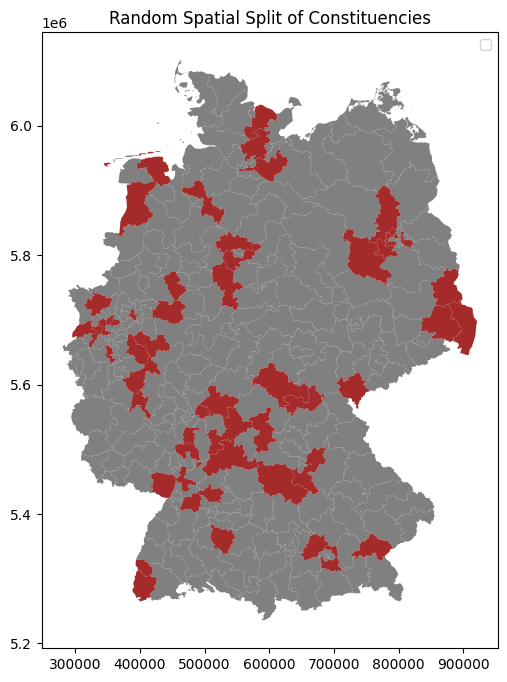

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
df_train.plot(ax=ax, color="grey", label="Train")
df_test.plot(ax=ax, color="brown", label="Test")
plt.legend()
plt.title("Random Spatial Split of Constituencies")
plt.show()


**Feature Selection Summary**
Feature selection is based on applying VIF score to the datset. VIF higher than 10 there is significant multicollinearity that needs to be corrected hence these values were removed.

Selecting variables, splitting data, grid search

In [9]:
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score


features=[    'east','percentAfD21','prop_foreigners_mean', 'avg_age_mean'
    ,'avg_rent_SQM_mean', 'avg_livingspace_mean', 'population_count_sum',
     'proportion_agriculture_interpolated',
    'disposable_income_interpolated','proportion_residential_transport_interpolated',
    'unemployment_rate_interpolated', 'crime_count_per100.000_interpolated',
    'distance_terror','area_sqm','prop_18-29']
target = 'percentAfD25'

# Drop rows with missing values first — preserve original indices
df = df.dropna(subset=[target] + features)

# OPTIONAL: only reset index if you truly need a clean sequential index
# df = df.reset_index(drop=True)

# Define X and y AFTER dropna (with original aligned index)
X = df[features]
y = df[target]

# Now split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the base model
rf = RandomForestRegressor(random_state=42)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2']
}

# Grid Search
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,
                           scoring='r2',
                           n_jobs=-1,
                           verbose=1)

# Fit to training data
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 200}


Train Non Spatial RF, calculating R2, MAE, Importance Features, Moran's I

In [11]:
# Make sure we keep the original index for the test set

# Train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Feature importance analysis
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

print("\nFeature Importances:")
print(importances)


Mean Absolute Error: 0.8596
R² Score: 0.9826

Feature Importances:
percentAfD21                                     0.896055
prop_18-29                                       0.053780
avg_rent_SQM_mean                                0.023259
avg_age_mean                                     0.004775
area_sqm                                         0.004003
distance_terror                                  0.003476
proportion_residential_transport_interpolated    0.002385
crime_count_per100.000_interpolated              0.002261
proportion_agriculture_interpolated              0.002212
avg_livingspace_mean                             0.002017
population_count_sum                             0.001765
prop_foreigners_mean                             0.001606
unemployment_rate_interpolated                   0.001304
disposable_income_interpolated                   0.000993
east                                             0.000110
dtype: float64


In [17]:
from libpysal.weights import Queen
from esda.moran import Moran

# Use index from X_test instead of y_test
test_set = df.loc[X_test.index]  # Must match the spatial dataframe's original index

# Calculate residuals
residuals = np.array(y_test) - np.array(y_pred)

# Create spatial weights
weights = Queen.from_dataframe(test_set)
weights.transform = 'r'

# Calculate Moran's I
moran = Moran(residuals, weights)

print(f"Moran's I: {moran.I}")
print(f"Z-score: {moran.z_sim}")
print(f"P-value: {moran.p_sim}")


<ipython-input-17-eeba349e2c18>:11: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  weights = Queen.from_dataframe(test_set)


('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 19, ' is an island (no neighbors)')
('WARNING: ', 32, ' is an island (no neighbors)')
('WARNING: ', 38, ' is an island (no neighbors)')
('WARNING: ', 46, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
Moran's I: 0.204306105573835
Z-score: 1.4180958842267204
P-value: 0.084


<ipython-input-21-2ef54bffee40>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  afd_cmap = cm.get_cmap("YlOrRd")


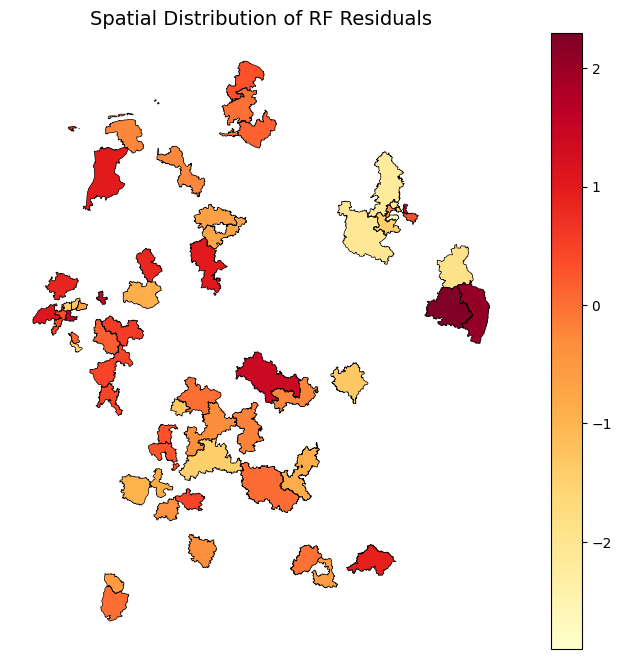

In [21]:
# Plot the residuals
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Color map
afd_cmap = cm.get_cmap("YlOrRd")

# Add residuals as a new column
test_set["residuals"] = residuals

fig, ax = plt.subplots(figsize=(10, 8))

# Plot residuals
test_set.plot(column="residuals", cmap=afd_cmap, legend=True, ax=ax)

# Add borders
test_set.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Styling
ax.set_title("Spatial Distribution of RF Residuals", fontsize=14)
ax.axis('off')

plt.show()

**3. Spatially-Aware Random Forest**
- Geographic Split Re-split daata using spatial clustering to avoid leakage through hierarchical clustering on region centroids
- Spatial Lag Calculation
- Recalculate R2 and MAE
- Residual Analysis & Visualisation
- New Moran's I

In [26]:
import libpysal
import geopandas as gpd

# Assume df is already a GeoDataFrame with a geometry column
gdf = df.copy()

# Create spatial weights using Queen contiguity
w = libpysal.weights.Queen.from_dataframe(gdf)

# Check spatial weights matrix
w_matrix = w.full()[0]  # Get the full adjacency matrix (0/1 values indicating neighbors)

# Save the spatial weights for later use
gdf['spatial_weights'] = list(w_matrix)

# can now use 'w' and 'spatial_weights' for further analysis and modeling


<ipython-input-26-1f0ce54b8493>:8: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(gdf)


Incorporate the Spatial Weights in the Model
To make use of the spatial weights, we can compute spatial lags for each feature (i.e., create new variables that represent the average values of each feature in neighboring regions, weighted by contiguity).


The purpose of selecting these columns in the final gdf[['WKR_NAME', 'percentAfD25', 'spatial_lag']] is to display and check the relationship between the region names, the original AfD support values, and the calculated spatial lag values. These columns are directly relevant to the spatial analysis and model interpretation.



In [27]:
from libpysal import weights
from pysal.model import spreg

# Calculate spatial lag of the target variable (percentAfD25)
y = gdf['percentAfD25'].values  # AfD support 2025
lag = weights.lag_spatial(w, y)

# Add the spatial lag to the GeoDataFrame
gdf['spatial_lag'] = lag

# Check the results
gdf[['WKR_NAME', 'percentAfD25', 'spatial_lag']].head()


,WKR_NAME,percentAfD25,spatial_lag
0,Flensburg – Schleswig,15.256022,32.085583
1,Nordfriesland – Dithmarschen Nord,16.065402,51.636220
2,Steinburg – Dithmarschen Süd,20.360017,102.930757
3,Rendsburg-Eckernförde,16.020181,80.438215
4,Kiel,10.753199,34.023756


However we should not apply the same approach directly to the spatial dataset (gdf) in this case.

The reason is that state-based splitting assumes that splitting by "LAND_NAME" is sufficient to preserve spatial integrity, which works in the non-spatial model but doesn't consider the spatial dependencies within each state. In the case of spatial data, regions within the same state might still be highly spatially correlated.

To make the split spatially conscious, we need to ensure that the training and test sets are from non-overlapping, spatially distinct regions. Simply selecting random states may still allow for spatial leakage within those states.

A better approach would be to:

Group by geographical areas (e.g., districts or regions) or

Split the data based on spatial clusters, ensuring that training and test sets contain spatially distinct regions.

This ensures that the spatial structure of the data is respected.

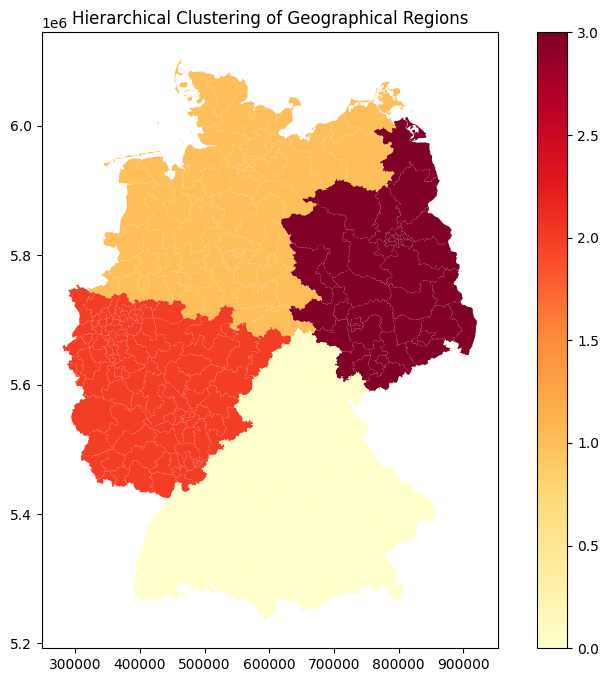

In [28]:
import geopandas as gpd
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Step 1: Prepare the data
# We’ll use the coordinates (centroids) of the geometry for clustering
gdf['centroid'] = gdf.geometry.centroid
gdf['x'] = gdf['centroid'].x
gdf['y'] = gdf['centroid'].y

# Step 2: Perform hierarchical clustering (Agglomerative Clustering)
# Use Euclidean distance, the most common metric for clustering
X = np.array(gdf[['x', 'y']])  # Extract centroid coordinates
clustering = AgglomerativeClustering(n_clusters=4, linkage='ward')  # Ward minimizes variance
gdf['cluster'] = clustering.fit_predict(X)

# Step 3: Visualize the clusters on the map
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(column='cluster', ax=ax, legend=True, cmap=afd_cmap)
plt.title("Hierarchical Clustering of Geographical Regions")
plt.show()


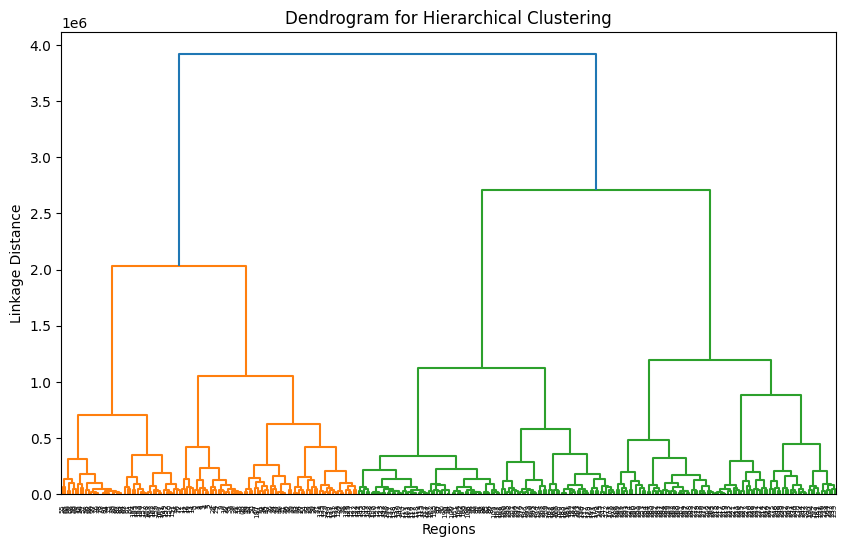

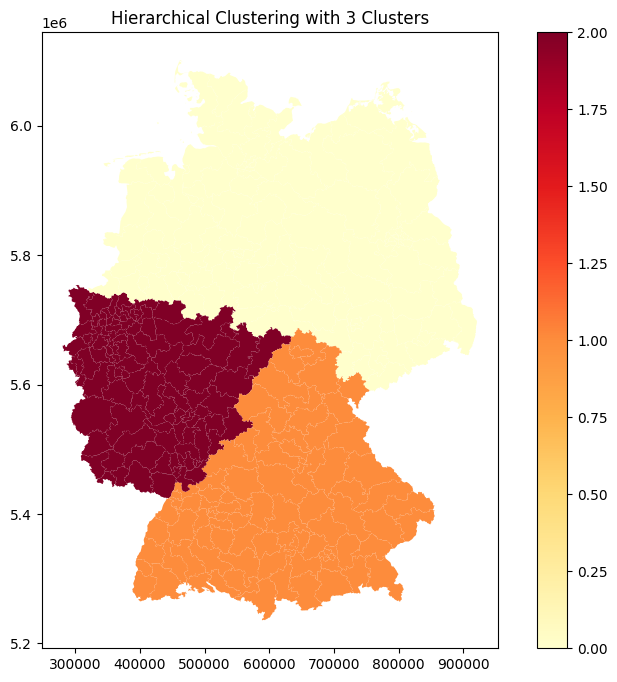

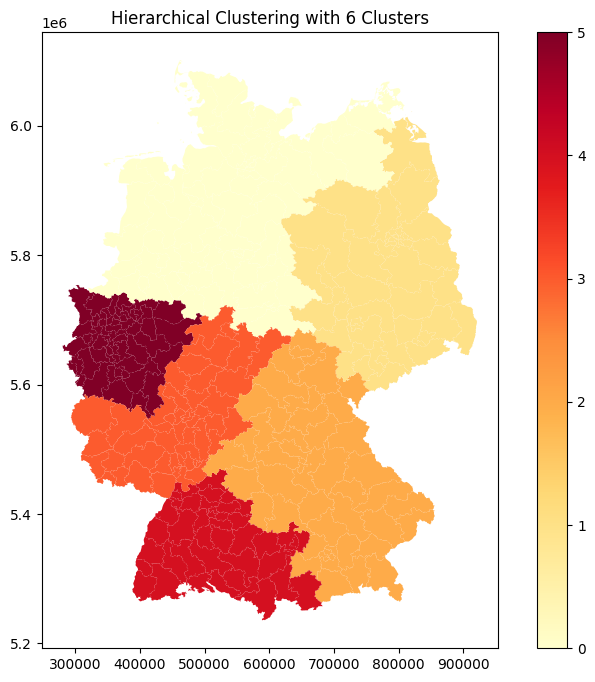

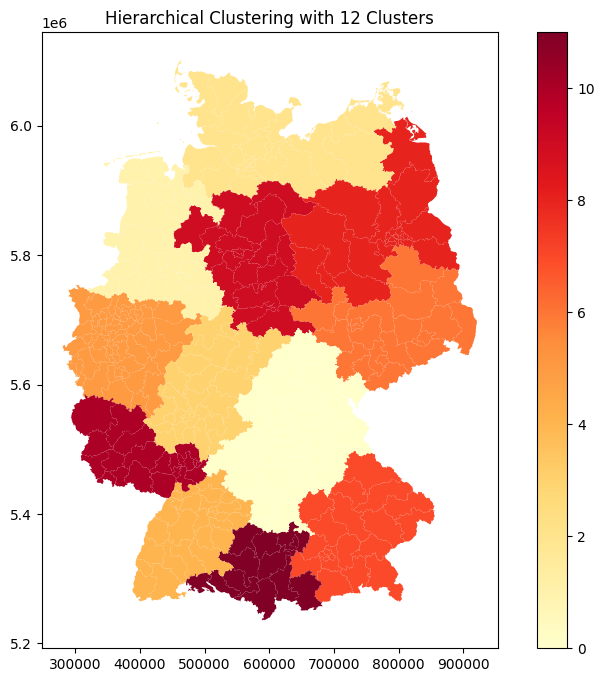

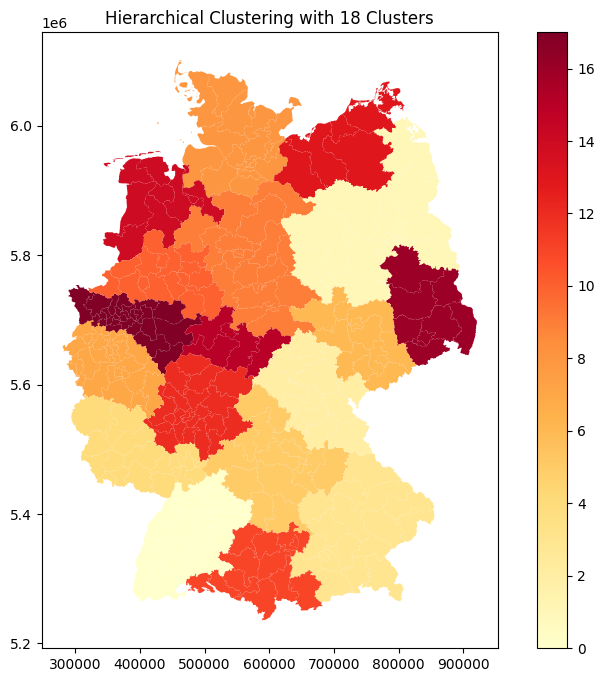

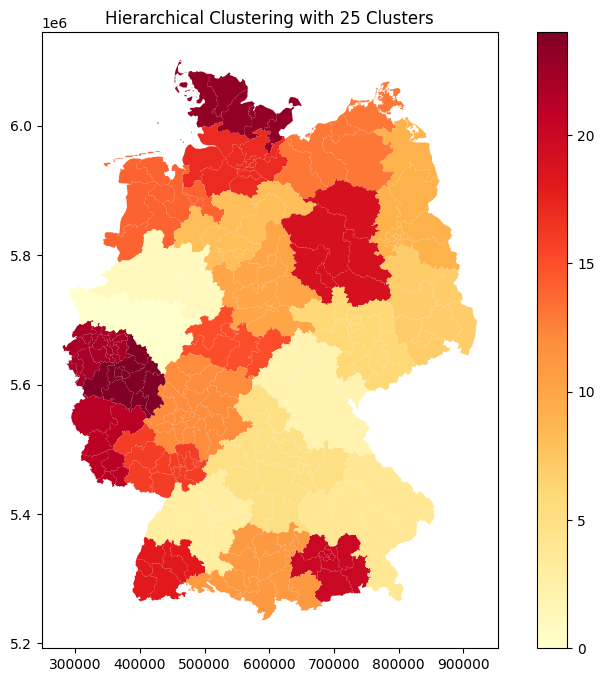

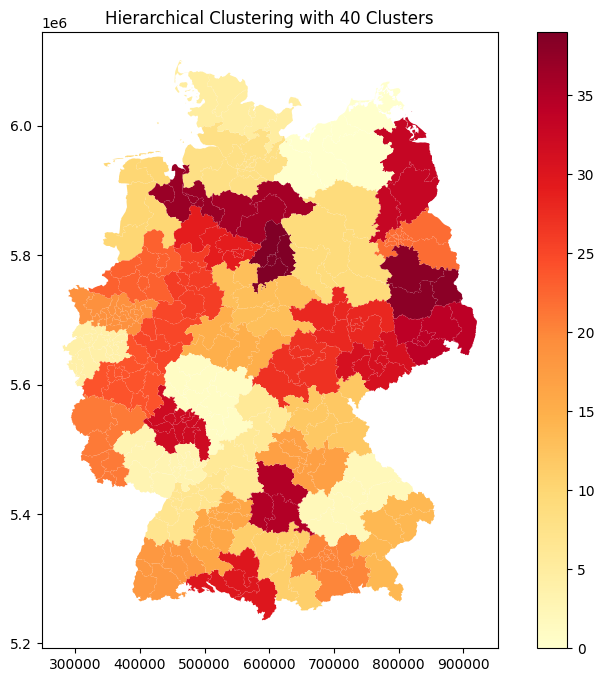

In [29]:
# import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist

# Load data and extract centroid coordinates
gdf['centroid'] = gdf.geometry.centroid
gdf['x'] = gdf['centroid'].x
gdf['y'] = gdf['centroid'].y
X = np.array(gdf[['x', 'y']])

# Compute linkage matrix for dendrogram
linkage_matrix = sch.linkage(X, method='ward')

# Step 1: Plot dendrogram to find natural breaks
plt.figure(figsize=(10, 6))
sch.dendrogram(linkage_matrix, truncate_mode='level', p=10)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Regions")
plt.ylabel("Linkage Distance")
plt.show()

# Step 2: Loop through natural cluster counts and visualize
cluster_counts = [3, 6, 12, 18, 25,40]  # Adjust based on dendrogram

for n_clusters in cluster_counts:
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    gdf[f'cluster_{n_clusters}'] = clustering.fit_predict(X)

    # Step 3: Visualize the clusters on a map
    fig, ax = plt.subplots(figsize=(10, 8))
    gdf.plot(column=f'cluster_{n_clusters}', ax=ax, legend=True, cmap=afd_cmap)
    plt.title(f"Hierarchical Clustering with {n_clusters} Clusters")
    plt.show()

In [30]:
from sklearn.model_selection import train_test_split

# Step 4: Assign clusters from the 25-cluster solution
gdf['final_cluster'] = gdf['cluster_25']

# Step 5: Select clusters for train/test split
unique_clusters = gdf['final_cluster'].unique()
train_clusters, test_clusters = train_test_split(unique_clusters, test_size=5/25, random_state=42)  # 5 clusters for test

# Step 6: Create train and test sets
train_set = gdf[gdf['final_cluster'].isin(train_clusters)]
test_set = gdf[gdf['final_cluster'].isin(test_clusters)]

# Step 7: Verify split
print(f"Train set: {len(train_set)} regions across {len(train_clusters)} clusters")
print(f"Test set: {len(test_set)} regions across {len(test_clusters)} clusters")


Train set: 227 regions across 20 clusters
Test set: 72 regions across 5 clusters


We started by using hierarchical clustering to find a meaningful number of clusters for splitting the dataset. The dendrogram helped identify natural breakpoints, and we settled on 25 clusters as a balance between granularity and generalization. Instead of arbitrarily selecting one cluster as the test set, we decided on a randomized cluster-based split to ensure diversity and prevent overfitting to a specific region. We used train_test_split to randomly assign 5 out of 25 clusters to testing while keeping the rest for training, ensuring a fair representation of geographic variance. This method keeps the spatial structure intact while allowing for a robust train-test separation.









Calculate spatial lag, add to list of features, Grid search, Spatial Random Forest

In [31]:
import geopandas as gpd
from libpysal import weights
from pysal.model import spreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold
import numpy as np
from sklearn.metrics import mean_squared_error

# Step 1: Calculate Spatial Weights (Already done earlier)
w = weights.Queen.from_dataframe(gdf)  # Queen contiguity for spatial weights

# Step 2: Calculate Spatial Lag for 'percentAfD25'
y = gdf['percentAfD25'].values  # Target variable
lag = weights.lag_spatial(w, y)  # Spatial lag calculation

# Step 3: Add Spatial Lag to GeoDataFrame
gdf['spatial_lag'] = lag

# Step 4: Prepare Features for the Spatial Random Forest
features = [
    'east', 'percentAfD21', 'prop_foreigners_mean', 'avg_age_mean',
    'avg_rent_SQM_mean', 'avg_livingspace_mean', 'population_count_sum',
    'proportion_agriculture_interpolated', 'disposable_income_interpolated',
    'proportion_residential_transport_interpolated', 'unemployment_rate_interpolated',
    'crime_count_per100.000_interpolated', 'distance_terror', 'area_sqm',
    'prop_18-29', 'spatial_lag'  # Include spatial lag as a feature
]

# Step 5: Set up the Training and Test Sets based on selected clusters
df_train = gdf[gdf['final_cluster'].isin(train_clusters)]
df_test = gdf[gdf['final_cluster'].isin(test_clusters)]

# Clean train_set and test_set by converting object types to numeric where necessary
def clean_data(df):
    for column in df.select_dtypes(include=['object']).columns:
        try:
            df[column] = df[column].str.replace(',', '.').astype(float)
        except ValueError:
            print(f"Column '{column}' couldn't be converted to float")
    return df

df_train = clean_data(df_train)
df_test = clean_data(df_test)

# Define X_train and y_train using the specific features
X_train = df_train[features]
y_train = df_train['percentAfD25']
X_test = df_test[features]
y_test = df_test['percentAfD25']

# Step 6: Set up Grid Search Parameters
param_grid = {
    'n_estimators': [50, 100, 150],          # Number of trees
    'max_depth': [10, 20, None],             # Depth of trees
    'min_samples_split': [2, 5, 10],         # Minimum samples to split
    'min_samples_leaf': [1, 2, 4],           # Minimum samples per leaf
    'max_features': ['sqrt', 'log2', None],  # Number of features per split
}

# Step 7: Set up the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Step 8: Set up GroupKFold using final_cluster
group_kfold = GroupKFold(n_splits=5)
groups = df_train['final_cluster']  # Use spatial cluster labels for grouping

# Step 9: Set up GridSearchCV with GroupKFold
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=group_kfold.split(df_train.drop(columns=['final_cluster']), df_train['percentAfD25'], groups=groups),
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# Step 10: Fit grid search
grid_search.fit(X_train, y_train)

# Step 11: Print the best parameters and best score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Cross-Validation MSE: {-grid_search.best_score_}')

# Step 12: Build the Best Model from Grid Search
best_rf = grid_search.best_estimator_

# Step 13: Predict on the Test Set
y_pred = best_rf.predict(X_test)

# Step 14: Evaluate Model Performance
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on Test Set: {mse}')

# The model will now only use the features explicitly defined in the 'features' list


<ipython-input-31-5203f8a47f8d>:10: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = weights.Queen.from_dataframe(gdf)  # Queen contiguity for spatial weights


Column 'WKR_NAME' couldn't be converted to float
Column 'LAND_NAME' couldn't be converted to float
Column 'Gebietsname' couldn't be converted to float
Column 'Gruppenname' couldn't be converted to float
Column 'WKR_NAME' couldn't be converted to float
Column 'LAND_NAME' couldn't be converted to float
Column 'Gebietsname' couldn't be converted to float
Column 'Gruppenname' couldn't be converted to float
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

Best Parameters: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation MSE: 2.9360065809114815
Mean Squared Error on Test Set: 1.8318249463104617


Calculate MAE, R2

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score

# Step 9: Calculate MAE and R2
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Absolute Error: 1.0539402365277788
R-squared: 0.9598915643071197


Calculate Feature Importance After Spatial Random Forest

In [33]:
# fit model to data
rf.fit(X_train, y_train)  # Ensure the model is fitted to the data

# Step 11: Plot Feature Importance
feature_importances = rf.feature_importances_
# Create a pandas Series to display feature importances as a table
importances = pd.Series(feature_importances, index=features).sort_values(ascending=False)

# Print the feature importances table
print("\nFeature Importances:")
print(importances)


Feature Importances:
percentAfD21                                     0.828261
prop_18-29                                       0.116891
avg_rent_SQM_mean                                0.026837
proportion_agriculture_interpolated              0.004220
distance_terror                                  0.004088
avg_livingspace_mean                             0.003885
area_sqm                                         0.003582
avg_age_mean                                     0.002238
crime_count_per100.000_interpolated              0.002027
proportion_residential_transport_interpolated    0.001984
spatial_lag                                      0.001526
population_count_sum                             0.001514
prop_foreigners_mean                             0.001322
unemployment_rate_interpolated                   0.000868
disposable_income_interpolated                   0.000629
east                                             0.000127
dtype: float64


Plot both Feature Importance values on bar chart

<ipython-input-34-ca6f842994a6>:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  afd_cmap = get_cmap("YlOrRd")


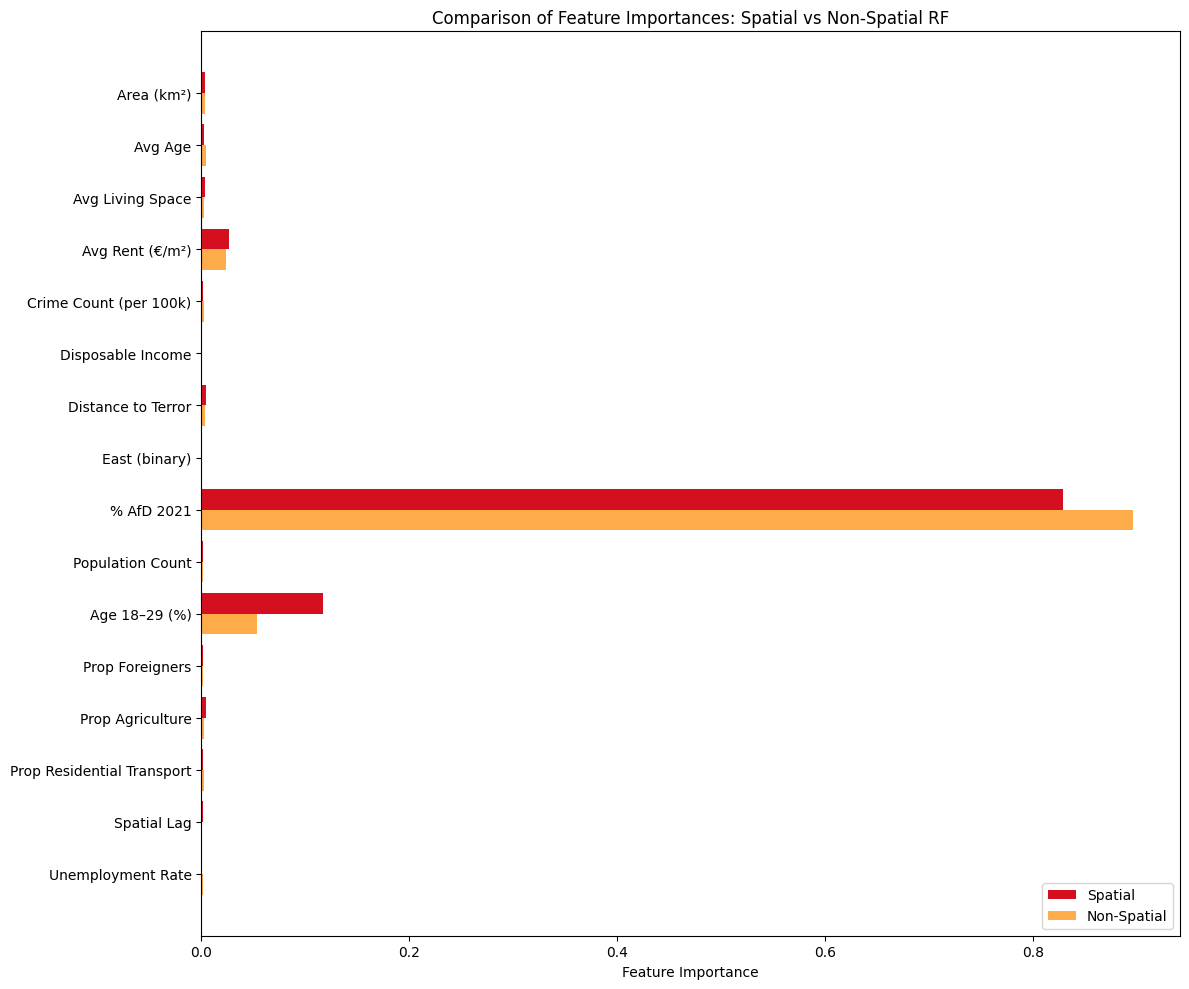

In [34]:
from matplotlib.cm import get_cmap

# Feature importance dictionaries
spatial_importances = {
    'percentAfD21': 0.828339,
    'prop_18-29': 0.116881,
    'avg_rent_SQM_mean': 0.026837,
    'proportion_agriculture_interpolated': 0.004225,
    'distance_terror': 0.004134,
    'avg_livingspace_mean': 0.003915,
    'area_sqm': 0.003584,
    'avg_age_mean': 0.002226,
    'crime_count_per100.000_interpolated': 0.002020,
    'proportion_residential_transport_interpolated': 0.001993,
    'spatial_lag': 0.001533,
    'population_count_sum': 0.001414,
    'prop_foreigners_mean': 0.001327,
    'unemployment_rate_interpolated': 0.000831,
    'disposable_income_interpolated': 0.000615,
    'east': 0.000127
}

non_spatial_importances = {
    'percentAfD21': 0.896064,
    'prop_18-29': 0.053876,
    'avg_rent_SQM_mean': 0.023329,
    'avg_age_mean': 0.004789,
    'area_sqm': 0.003898,
    'distance_terror': 0.003401,
    'proportion_residential_transport_interpolated': 0.002329,
    'crime_count_per100.000_interpolated': 0.002307,
    'proportion_agriculture_interpolated': 0.002186,
    'avg_livingspace_mean': 0.002113,
    'population_count_sum': 0.001780,
    'prop_foreigners_mean': 0.001606,
    'unemployment_rate_interpolated': 0.001230,
    'disposable_income_interpolated': 0.000983,
    'east': 0.000110
}

# Convert to DataFrames
spatial_df = pd.DataFrame(list(spatial_importances.items()), columns=['Feature', 'Importance_Spatial'])
non_spatial_df = pd.DataFrame(list(non_spatial_importances.items()), columns=['Feature', 'Importance_NonSpatial'])

# Merge for side-by-side plotting
importance_df = pd.merge(spatial_df, non_spatial_df, on="Feature", how="outer").fillna(0)

# (Optional) Force "spatial_lag" non-spatial value to zero explicitly if desired
importance_df.loc[importance_df["Feature"] == "spatial_lag", "Importance_NonSpatial"] = 0

# Clean feature names
def clean_feature_names(feature):
    replacements = {
        'percentAfD21': '% AfD 2021',
        'prop_18-29': 'Age 18–29 (%)',
        'avg_rent_SQM_mean': 'Avg Rent (€/m²)',
        'proportion_agriculture_interpolated': 'Prop Agriculture',
        'distance_terror': 'Distance to Terror',
        'avg_livingspace_mean': 'Avg Living Space',
        'area_sqm': 'Area (km²)',
        'avg_age_mean': 'Avg Age',
        'crime_count_per100.000_interpolated': 'Crime Count (per 100k)',
        'proportion_residential_transport_interpolated': 'Prop Residential Transport',
        'spatial_lag': 'Spatial Lag',
        'population_count_sum': 'Population Count',
        'prop_foreigners_mean': 'Prop Foreigners',
        'unemployment_rate_interpolated': 'Unemployment Rate',
        'disposable_income_interpolated': 'Disposable Income',
        'east': 'East (binary)'
    }
    return replacements.get(feature, feature)

importance_df["Readable_Feature"] = importance_df["Feature"].apply(clean_feature_names)

# Set color palette
afd_cmap = get_cmap("YlOrRd")
color_spatial = afd_cmap(0.8)
color_nonspatial = afd_cmap(0.4)

# Plot without log transform
fig, ax = plt.subplots(figsize=(12, 10))
bar_width = 0.4
indices = np.arange(len(importance_df))

ax.barh(indices - bar_width/2, importance_df["Importance_Spatial"],
        bar_width, label="Spatial", color=color_spatial)
ax.barh(indices + bar_width/2, importance_df["Importance_NonSpatial"],
        bar_width, label="Non-Spatial", color=color_nonspatial)

ax.set_yticks(indices)
ax.set_yticklabels(importance_df["Readable_Feature"])
ax.invert_yaxis()

ax.set_xlabel("Feature Importance")
ax.set_title("Comparison of Feature Importances: Spatial vs Non-Spatial RF")
ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.8)
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

<ipython-input-41-05ac9f659526>:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  afd_cmap = get_cmap("YlOrRd")


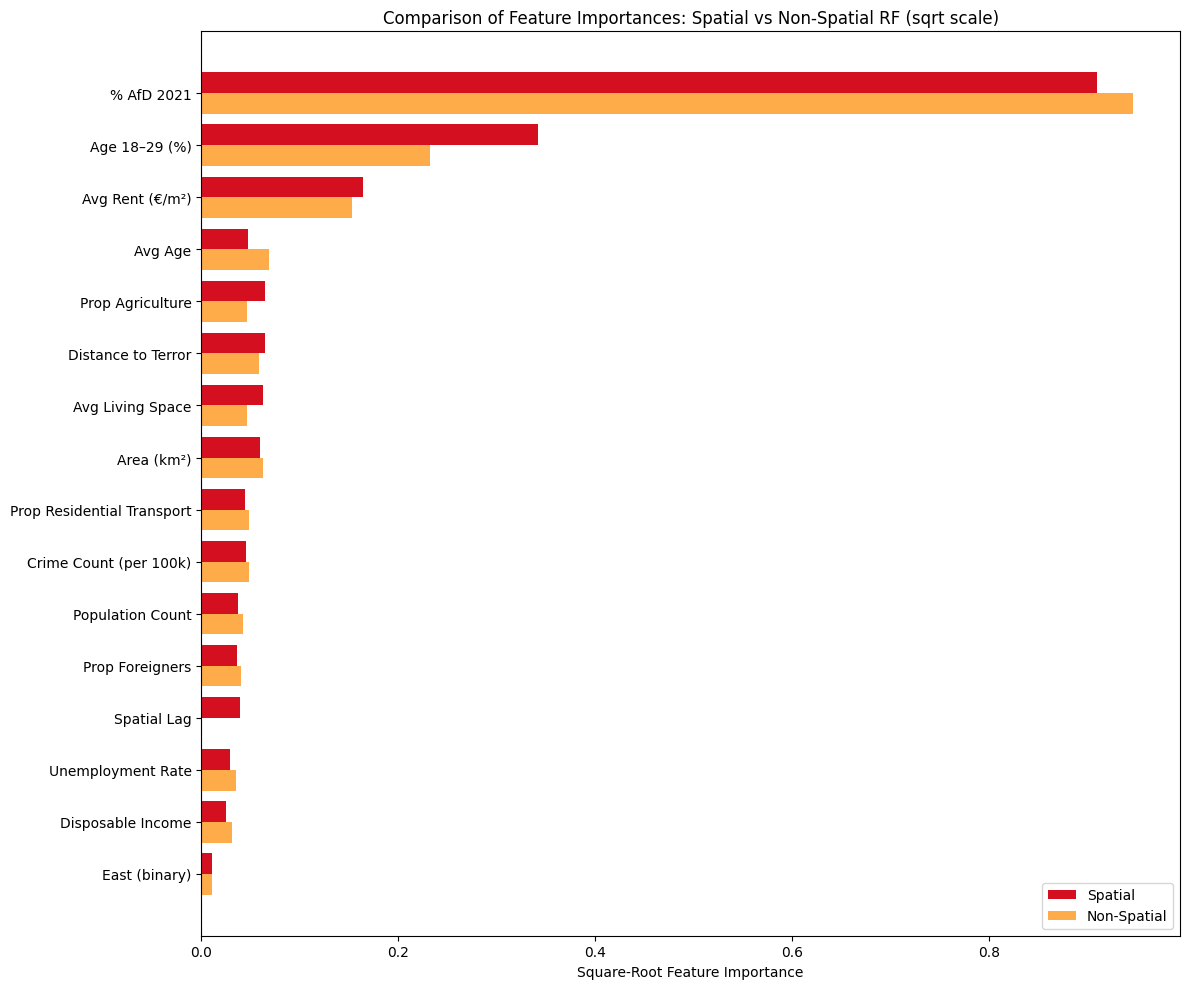

In [41]:
from matplotlib.cm import get_cmap

# Feature importance dictionaries
spatial_importances = {
    'percentAfD21': 0.828339,
    'prop_18-29': 0.116881,
    'avg_rent_SQM_mean': 0.026837,
    'proportion_agriculture_interpolated': 0.004225,
    'distance_terror': 0.004134,
    'avg_livingspace_mean': 0.003915,
    'area_sqm': 0.003584,
    'avg_age_mean': 0.002226,
    'crime_count_per100.000_interpolated': 0.002020,
    'proportion_residential_transport_interpolated': 0.001993,
    'spatial_lag': 0.001533,
    'population_count_sum': 0.001414,
    'prop_foreigners_mean': 0.001327,
    'unemployment_rate_interpolated': 0.000831,
    'disposable_income_interpolated': 0.000615,
    'east': 0.000127
}

non_spatial_importances = {
    'percentAfD21': 0.896064,
    'prop_18-29': 0.053876,
    'avg_rent_SQM_mean': 0.023329,
    'avg_age_mean': 0.004789,
    'area_sqm': 0.003898,
    'distance_terror': 0.003401,
    'proportion_residential_transport_interpolated': 0.002329,
    'crime_count_per100.000_interpolated': 0.002307,
    'proportion_agriculture_interpolated': 0.002186,
    'avg_livingspace_mean': 0.002113,
    'population_count_sum': 0.001780,
    'prop_foreigners_mean': 0.001606,
    'unemployment_rate_interpolated': 0.001230,
    'disposable_income_interpolated': 0.000983,
    'east': 0.000110
}

# Convert to DataFrames
spatial_df = pd.DataFrame(list(spatial_importances.items()), columns=['Feature', 'Importance_Spatial'])
non_spatial_df = pd.DataFrame(list(non_spatial_importances.items()), columns=['Feature', 'Importance_NonSpatial'])

# Merge for side-by-side plotting
importance_df = pd.merge(spatial_df, non_spatial_df, on="Feature", how="outer").fillna(0)

# (Optional) Force 'spatial_lag' non-spatial value to zero explicitly
importance_df.loc[importance_df["Feature"] == "spatial_lag", "Importance_NonSpatial"] = 0

# Clean feature names
def clean_feature_names(feature):
    replacements = {
        'percentAfD21': '% AfD 2021',
        'prop_18-29': 'Age 18–29 (%)',
        'avg_rent_SQM_mean': 'Avg Rent (€/m²)',
        'proportion_agriculture_interpolated': 'Prop Agriculture',
        'distance_terror': 'Distance to Terror',
        'avg_livingspace_mean': 'Avg Living Space',
        'area_sqm': 'Area (km²)',
        'avg_age_mean': 'Avg Age',
        'crime_count_per100.000_interpolated': 'Crime Count (per 100k)',
        'proportion_residential_transport_interpolated': 'Prop Residential Transport',
        'spatial_lag': 'Spatial Lag',
        'population_count_sum': 'Population Count',
        'prop_foreigners_mean': 'Prop Foreigners',
        'unemployment_rate_interpolated': 'Unemployment Rate',
        'disposable_income_interpolated': 'Disposable Income',
        'east': 'East (binary)'
    }
    return replacements.get(feature, feature)

importance_df["Readable_Feature"] = importance_df["Feature"].apply(clean_feature_names)

# Apply square-root transform (no normalization)
importance_df["Spatial_Sqrt"] = np.sqrt(importance_df["Importance_Spatial"])
importance_df["NonSpatial_Sqrt"] = np.sqrt(importance_df["Importance_NonSpatial"])


# Create a column to determine sorting order: the maximum of Spatial or Non-Spatial sqrt
importance_df["Max_Sqrt"] = importance_df[["Spatial_Sqrt", "NonSpatial_Sqrt"]].max(axis=1)
# Sort by max importance (descending)
importance_df.sort_values("Max_Sqrt", ascending=False, inplace=True)

# Plot
afd_cmap = get_cmap("YlOrRd")
color_spatial = afd_cmap(0.8)
color_nonspatial = afd_cmap(0.4)

fig, ax = plt.subplots(figsize=(12, 10))
bar_width = 0.4
indices = np.arange(len(importance_df))

ax.barh(indices - bar_width/2, importance_df["Spatial_Sqrt"],
        bar_width, label="Spatial", color=color_spatial)
ax.barh(indices + bar_width/2, importance_df["NonSpatial_Sqrt"],
        bar_width, label="Non-Spatial", color=color_nonspatial)

ax.set_yticks(indices)
ax.set_yticklabels(importance_df["Readable_Feature"])
ax.invert_yaxis()

ax.set_xlabel("Square-Root Feature Importance")
ax.set_title("Comparison of Feature Importances: Spatial vs Non-Spatial RF (sqrt scale)")
ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.8)
ax.legend(loc='lower right')

plt.tight_layout()

# Save figure to PNG
plt.savefig("feature_importances_sqrt.png", dpi=300, bbox_inches="tight")
plt.show()

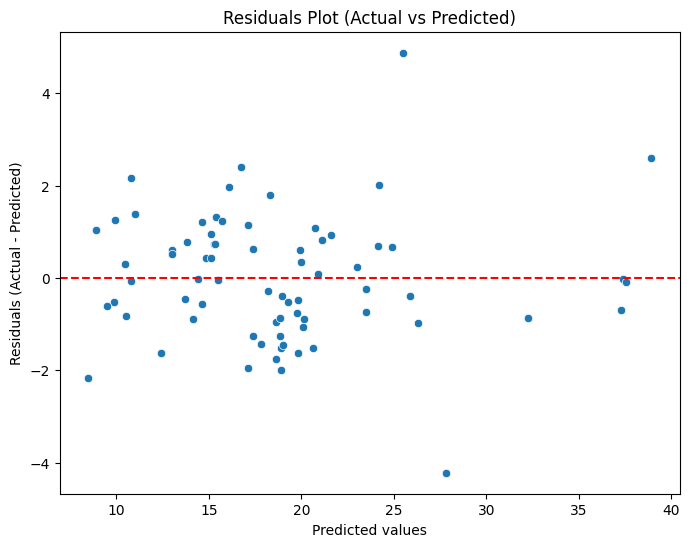

In [ ]:
# Step 12: Residuals Plot (Actual vs Predicted)
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals Plot (Actual vs Predicted)")
plt.xlabel("Predicted values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.show()


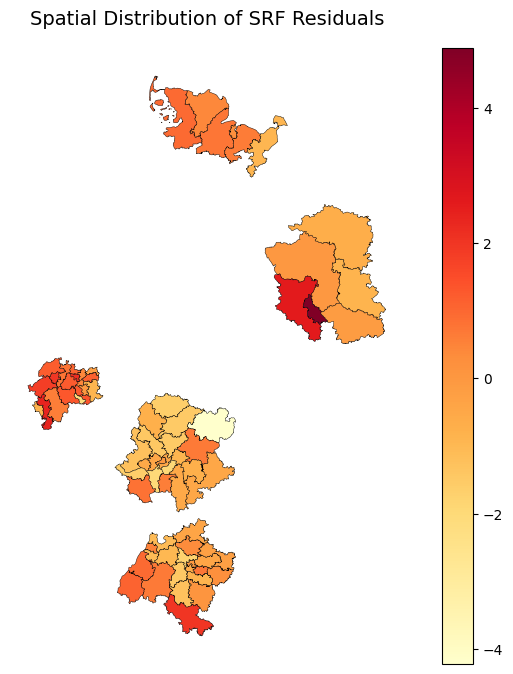

In [ ]:
test_set_map = test_set.copy()

# Add residuals as a new column
test_set_map["residuals"] = residuals

# Plot the spatial distribution of residuals
fig, ax = plt.subplots(figsize=(10, 8))
test_set_map.plot(
    column="residuals",
    cmap=afd_cmap,
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax
)

ax.set_title("Spatial Distribution of SRF Residuals", fontsize=14)
ax.axis("off")

plt.show()

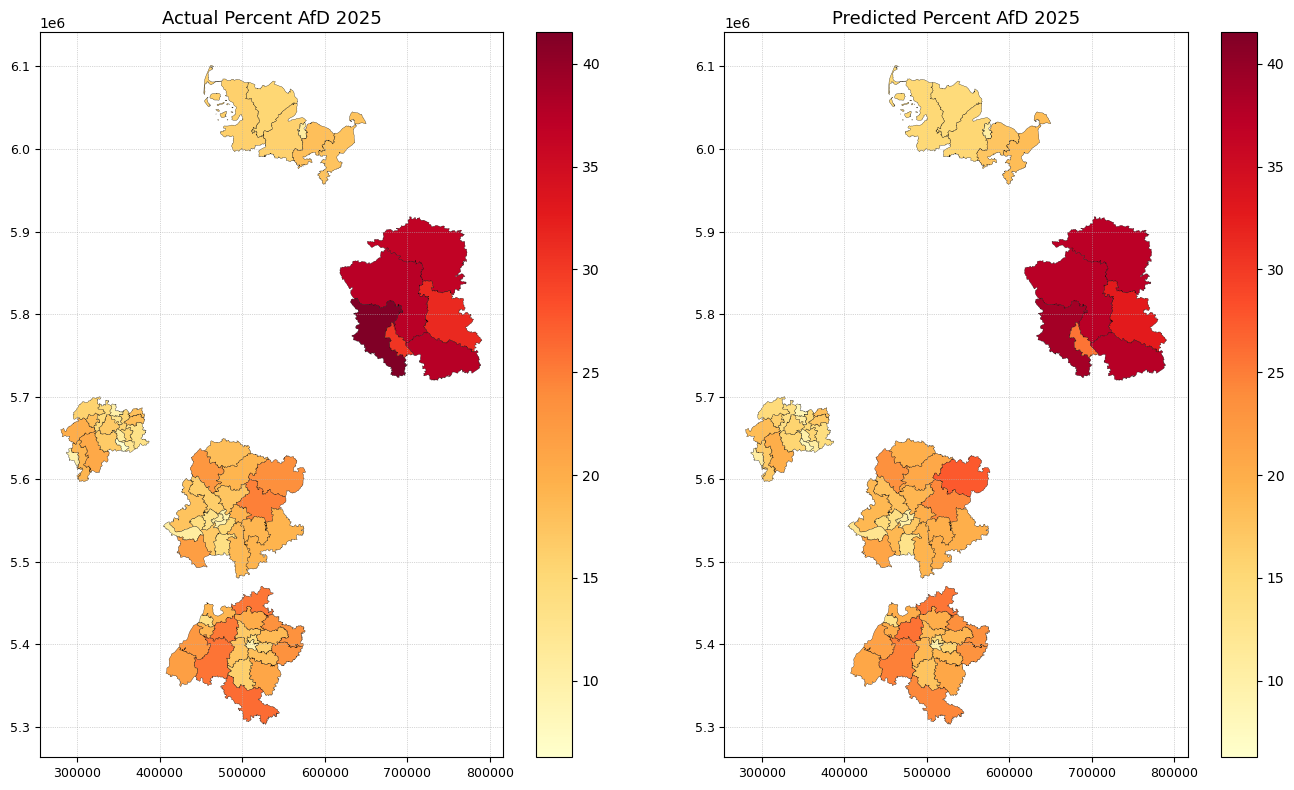

In [ ]:
# 14. Comparing Actual vs Predicted on the Map (GeoVisualization)

# Copy and add predictions
gdf_test = df_test.copy()
gdf_test['predicted_percentAfD25'] = y_pred

# Set shared color scale
vmin = min(gdf_test['percentAfD25'].min(), gdf_test['predicted_percentAfD25'].min())
vmax = max(gdf_test['percentAfD25'].max(), gdf_test['predicted_percentAfD25'].max())

# Plot
fig, ax = plt.subplots(1, 2, figsize=(14, 8))

# Actual
gdf_test.plot(
    column='percentAfD25',
    ax=ax[0],
    cmap=afd_cmap,
    legend=True,
    edgecolor='black',
    linewidth=0.2,
    vmin=vmin,
    vmax=vmax
)
ax[0].set_title("Actual Percent AfD 2025", fontsize=13)
ax[0].tick_params(labelsize=9)
ax[0].grid(True, linestyle=':', linewidth=0.5)

# Predicted
gdf_test.plot(
    column='predicted_percentAfD25',
    ax=ax[1],
    cmap=afd_cmap,
    legend=True,
    edgecolor='black',
    linewidth=0.2,
    vmin=vmin,
    vmax=vmax
)
ax[1].set_title("Predicted Percent AfD 2025", fontsize=13)
ax[1].tick_params(labelsize=9)
ax[1].grid(True, linestyle=':', linewidth=0.5)

# Layout
plt.tight_layout()
plt.show()

/var/folders/1t/_mjp562d32n0jpr_977zlv640000gn/T/ipykernel_2280/4080938554.py:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/var/folders/1t/_mjp562d32n0jpr_977zlv640000gn/T/ipykernel_2280/4080938554.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


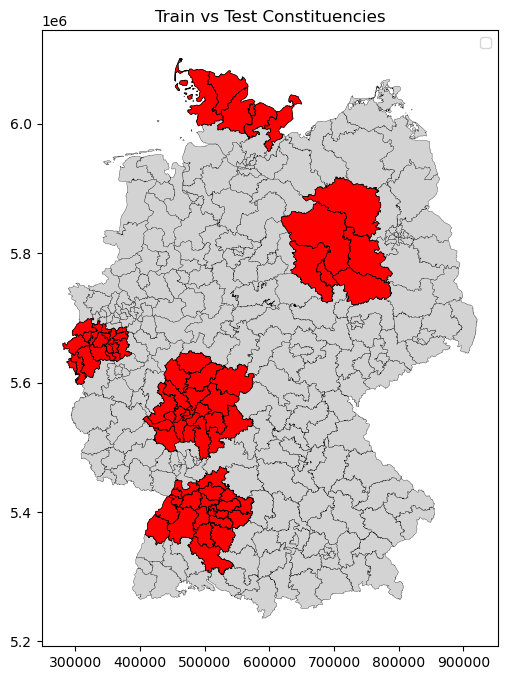

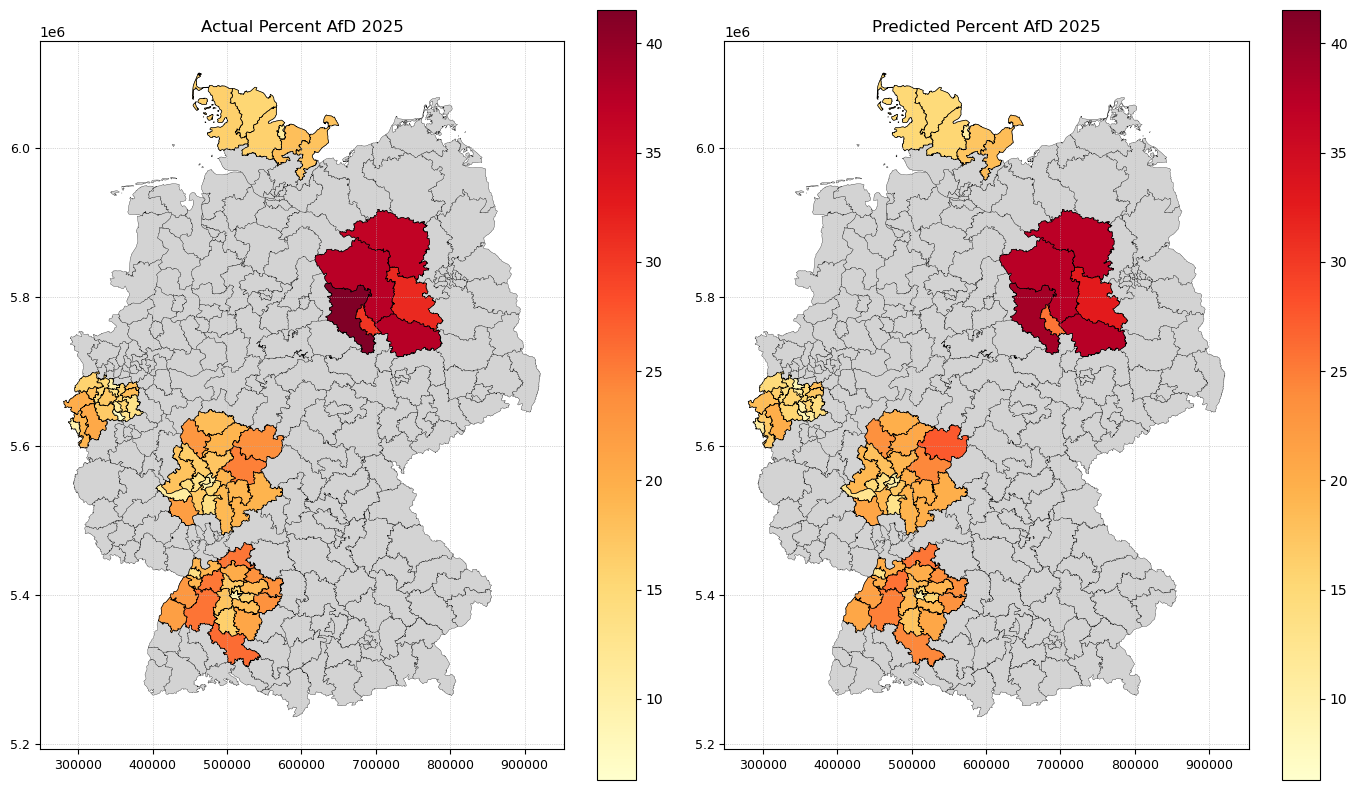

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Add predictions to gdf for mapping
gdf.loc[df_test.index, 'predicted_percentAfD25'] = y_pred

# === Step 1: Plot Train vs. Test areas ===
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.2, label='Train Set')
df_test.plot(ax=ax, color='red', edgecolor='black', linewidth=0.5, label='Test Set')
plt.title("Train vs Test Constituencies")
plt.legend()
plt.show()

# === Step 2: Actual vs. Predicted Maps with Full Context ===

# Define shared color scale
vmin = min(df_test['percentAfD25'].min(), gdf.loc[df_test.index, 'predicted_percentAfD25'].min())
vmax = max(df_test['percentAfD25'].max(), gdf.loc[df_test.index, 'predicted_percentAfD25'].max())

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 8))

# Actual
gdf.plot(ax=ax[0], color='lightgrey', edgecolor='black', linewidth=0.2)
df_test.plot(
    column='percentAfD25',
    ax=ax[0],
    cmap=afd_cmap,
    legend=True,
    edgecolor='black',
    linewidth=0.5,
    vmin=vmin,
    vmax=vmax
)
ax[0].set_title("Actual Percent AfD 2025")
ax[0].tick_params(labelsize=9)
ax[0].grid(True, linestyle=':', linewidth=0.5)

# Predicted
gdf.plot(ax=ax[1], color='lightgrey', edgecolor='black', linewidth=0.2)
gdf.loc[df_test.index].plot(
    column='predicted_percentAfD25',
    ax=ax[1],
    cmap=afd_cmap,
    legend=True,
    edgecolor='black',
    linewidth=0.5,
    vmin=vmin,
    vmax=vmax
)
ax[1].set_title("Predicted Percent AfD 2025")
ax[1].tick_params(labelsize=9)
ax[1].grid(True, linestyle=':', linewidth=0.5)

# Layout
plt.tight_layout()
plt.show()

In [ ]:
import libpysal
from libpysal.weights import Queen
from esda.moran import Moran
import numpy as np

# Ensure y_test and y_pred are numpy arrays and have the same length
y_test = np.array(y_test)
y_pred = np.array(y_pred)

# Ensure y_test and y_pred have the same length
if len(y_test) != len(y_pred):
    raise ValueError(f"Length mismatch: y_test has length {len(y_test)}, y_pred has length {len(y_pred)}")

# Assuming test_set is a GeoDataFrame corresponding to the test set regions (72 regions)
# Filter test_set if necessary to ensure it matches the number of residuals
residuals = (y_test - y_pred)

# Create spatial weights based on the test set's spatial units
weights = Queen.from_dataframe(test_set)  # Create spatial weights from the test set GeoDataFrame
weights_matrix = weights.full()[0]  # Convert to dense format if needed

# Perform Moran's I on the residuals
moran_residuals = Moran(residuals, weights)

# Print Moran's I results
print(f'Moran\'s I: {moran_residuals.I}')
print(f'Z-score: {moran_residuals.z_sim}')
print(f'p-value: {moran_residuals.p_sim}')


Moran's I: 0.29405181349843085
Z-score: 3.6290435646728425
p-value: 0.002


/var/folders/1t/_mjp562d32n0jpr_977zlv640000gn/T/ipykernel_2280/4219216326.py:19: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  weights = Queen.from_dataframe(test_set)  # Create spatial weights from the test set GeoDataFrame
/opt/anaconda3/envs/geospatial/lib/python3.11/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


The goal here is to assess whether the residuals (errors) from a model exhibit any spatial autocorrelation. This is often done in spatial econometrics to detect if the model's errors are spatially correlated, indicating potential issues such as spatial dependence that should be addressed in the model.

In [ ]:
import libpysal
from libpysal.weights import Queen
from esda.moran import Moran
import numpy as np

# Assuming gdf contains the relevant data
# Extract the variable you're interested in (e.g., 'percentAfD25')
variable = gdf['percentAfD25'].values

# Create spatial weights based on the geographic units in gdf
weights = Queen.from_dataframe(gdf)  # Create spatial weights from the GeoDataFrame
weights_matrix = weights.full()[0]  # Convert to dense format if needed

# Perform Moran's I on the selected variable (percentAfD25)
moran_variable = Moran(variable, weights)

# Print Moran's I results for the variable
print(f'Moran\'s I for percentAfD25: {moran_variable.I}')
print(f'Z-score: {moran_variable.z_sim}')
print(f'p-value: {moran_variable.p_sim}')


/var/folders/1t/_mjp562d32n0jpr_977zlv640000gn/T/ipykernel_2280/4255898532.py:11: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  weights = Queen.from_dataframe(gdf)  # Create spatial weights from the GeoDataFrame


Moran's I for percentAfD25: 0.7463037140141963
Z-score: 20.811393551640418
p-value: 0.001


The purpose here is to assess the spatial autocorrelation of a specific variable ('percentAfD25'). This is done to determine if the values of this variable are spatially clustered or dispersed in the study area.

## Explainable AI plots

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import shap
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

### Partial Dependence Plots

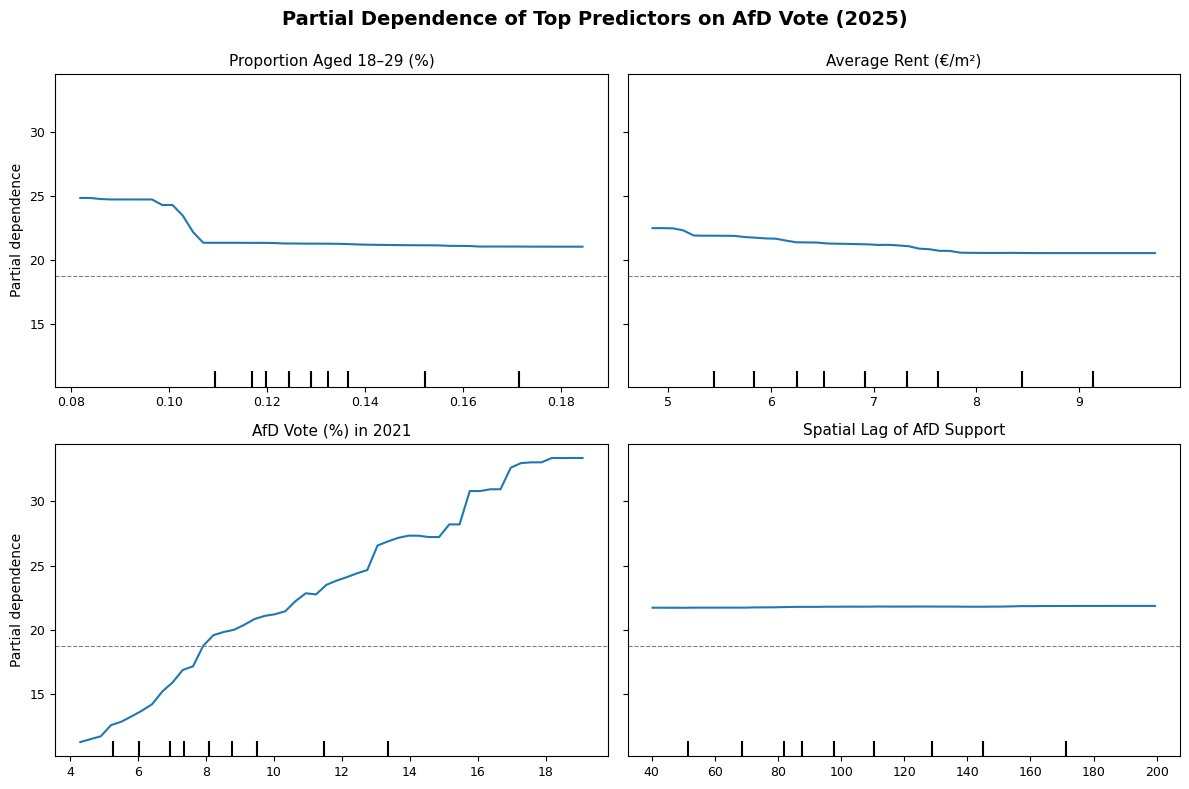

In [ ]:
features = ["prop_18-29", "avg_rent_SQM_mean", "percentAfD21", "spatial_lag"]

# Create figure and display PDP
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
display = PartialDependenceDisplay.from_estimator(
    rf,
    X_test,
    features=features,
    ax=ax,
    kind='average',
    grid_resolution=50
)

# Customize subplots
titles = {
    "prop_18-29": "Proportion Aged 18–29 (%)",
    "avg_rent_SQM_mean": "Average Rent (€/m²)",
    "percentAfD21": "AfD Vote (%) in 2021",
    "spatial_lag": "Spatial Lag of AfD Support"
}

for axs, name in zip(ax.ravel(), features):
    axs.set_title(titles[name], fontsize=11)
    axs.set_xlabel("")
    axs.axhline(y=y_pred.mean(), linestyle="--", color="gray", linewidth=0.8)
    axs.tick_params(axis='both', labelsize=9)

fig.suptitle("Partial Dependence of Top Predictors on AfD Vote (2025)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

* The model predicts higher AfD support in 2025 primarily in areas where the party already performed well in 2021.
* A higher share of young people (ages 18–29) and more expensive housing are both associated with slightly lower predicted AfD support.
* Interestingly, the spatial lag — capturing neighboring support levels — shows no clear average effect.

### Further investigation of spatial lag

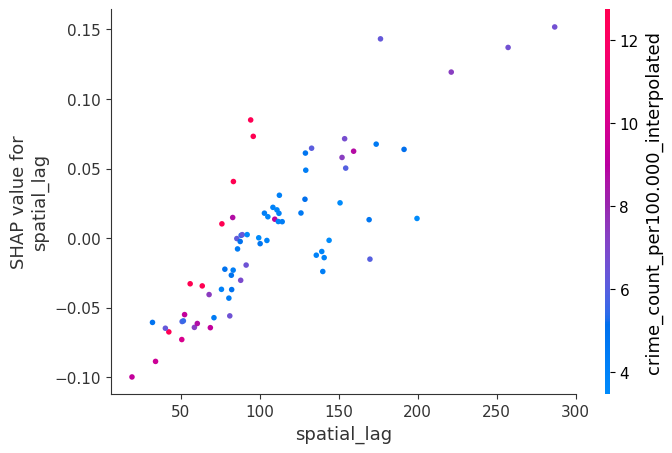

In [ ]:
# Check crime and spatial lag interactions (Crime is frequently linked in literature to support for populist or far-right parties.)
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# SHAP dependence plot for spatial_lag
shap.dependence_plot("spatial_lag", shap_values, X_test)

Insight: There’s a mild interaction with crime — high-crime areas show slightly lower SHAP values (reddish dots clustering at lower SHAP), but not a dominant effect.

Shows that spatial lag is predictive of AfD support, independently of crime.

Text(0.5, 1.0, 'Spatial Lag of AfD Support (2025)')

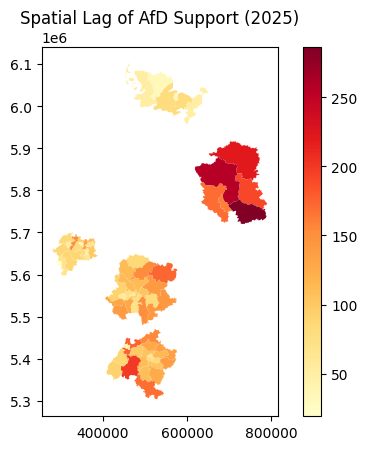

In [ ]:
# Remember afd support lag map
gdf_test["spatial_lag"] = X_test["spatial_lag"]
gdf_test.plot(column="spatial_lag", cmap=afd_cmap, legend=True)
plt.title("Spatial Lag of AfD Support (2025)")

Insight: AfD voting is spatially contagious — it tends to spill over across neighboring areas.

In [ ]:
# Check a group summary of spatial lag
gdf_test["spatial_lag_bin"] = pd.qcut(X_test["spatial_lag"], q=3, labels=["Low", "Mid", "High"])
gdf_test.groupby("spatial_lag_bin")["percentAfD25"].mean()

<ipython-input-81-b659591a0e84>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gdf_test.groupby("spatial_lag_bin")["percentAfD25"].mean()


,percentAfD25
spatial_lag_bin,
Low,14.402703
Mid,17.473831
High,24.347329


Insight: A clear jump in predicted AfD support in areas with high spatial lag.

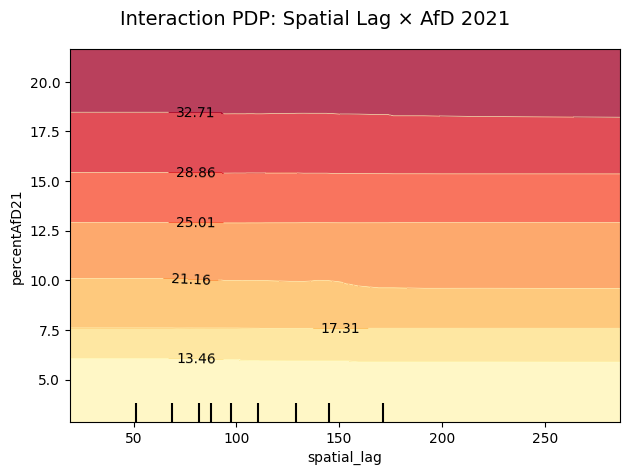

In [ ]:
# Check how the joint effect of spatial_lag and 2021 AfD vote affects predicted 2025 vote share

# Generate the PDP with interaction
disp = PartialDependenceDisplay.from_estimator(
    rf,
    X_test,
    features=[("spatial_lag", "percentAfD21")],
    kind='average'
)

# Manually update colormap for each contour in each axis
for ax in disp.axes_.flat:
    for contour in ax.collections:
        contour.set_cmap(afd_cmap)

# Title and layout
plt.suptitle("Interaction PDP: Spatial Lag × AfD 2021", fontsize=14)
plt.tight_layout()
plt.show()

Insight: While spatial_lag has an effect, the dominant driver is percentAfD21 (Going up the y-axis increases predicted 2025 support sharply).

At each level of percentAfD21, increasing spatial lag does not boost 2025 support.

That means spatial spillover is weak or absorbed elsewhere (e.g., already captured by percentAfD21).

### SHAP value

<ipython-input-93-f8c9e9b1533e>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  afd_cmap = cm.get_cmap("YlOrRd")
<ipython-input-93-f8c9e9b1533e>:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


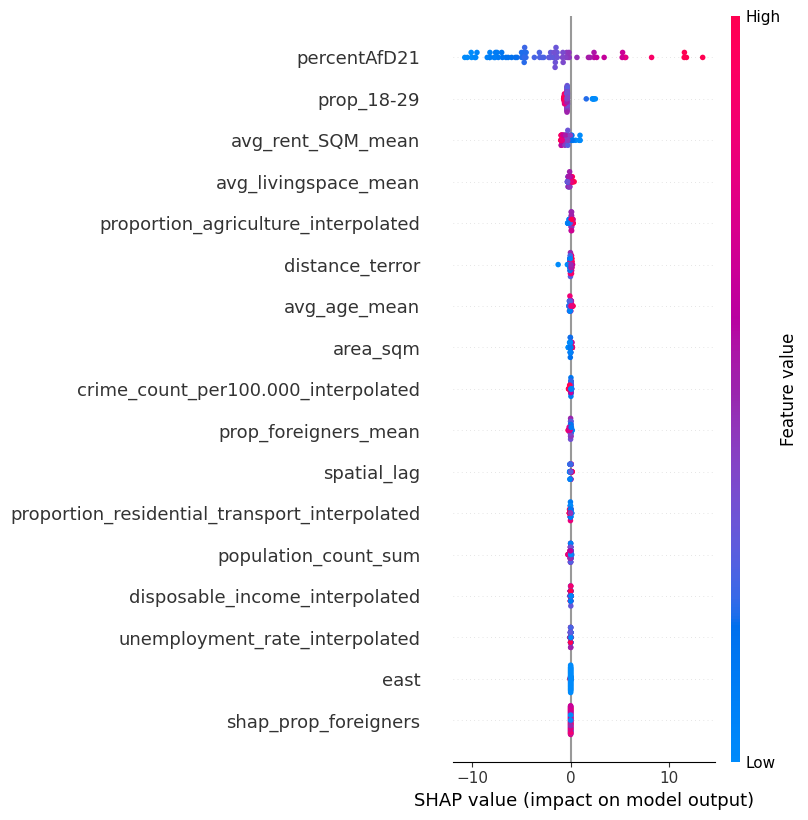

In [ ]:
# SHAP (SHapley Additive exPlanations) values show how much each feature contributes to a specific prediction – either increasing it or decreasing it
# – compared to the average prediction. Model prediction = average prediction + sum of SHAP values for all features
# Y-axis (features): Features are ordered top to bottom by overall importance (based on average absolute SHAP values)
# X-axis (SHAP value): Shows how much a feature pushed the prediction up or down for a specific instance (constituency).
# Right = higher predicted AfD support.
# Left = lower predicted AfD support.


# SHAP Explainer and values
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Use the YlOrRd colormap for AfD-style color
afd_cmap = cm.get_cmap("YlOrRd")

# Plot SHAP summary
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="dot",
    color=afd_cmap
)